In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/Colab Notebooks/
%ls

# Set-UP


In [ ]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle # pour charger le modèle
import pandas as pd
import string
from random import randint
import re
from tabulate import tabulate
import time
import numpy as np
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns


# librairies scikit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# librairies associées à NLTK
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

from MyNLPUtilities import *
from CleanText import *

from tensorflow import keras
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Jeux de données

**DONNÉES D'ENTRAINEMENT**

In [ ]:
df_imdb = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='\t', encoding='utf8')

print ("les 10 premières lignes du fichier :")
display(df_imdb[0:10])
print ("la taille du fichier : ", df_imdb.shape)
print ("le nombre d'avis différents : \n",df_imdb['sentiment'].value_counts(),'\n')
print ("Un exemple d'avis \n",df_imdb['sentence'][0],'\n')

les 10 premières lignes du fichier :


,sentence,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
5,I have to jiggle the plug to get it to line up...,0,amazon
6,If you have several dozen or several hundred c...,0,amazon
7,If you are Razr owner...you must have this!,1,amazon
8,"Needless to say, I wasted my money.",0,amazon
9,What a waste of money and time!.,0,amazon


la taille du fichier :  (3000, 3)
le nombre d'avis différents : 
 1    1500
0    1500
Name: sentiment, dtype: int64 

Un exemple d'avis 
 So there is no way for me to plug it in here in the US unless I go by a converter. 



**DONNÉES DE TEST**

In [ ]:
df_movie = pd.read_csv("movie_data.csv", names=['sentence','sentiment'], header=0,sep=',', encoding='utf8')
display(df_movie[0:10])
print(df_movie.shape)

,sentence,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
5,"I saw this film on September 1st, 2005 in Indi...",1
6,"Maybe I'm reading into this too much, but I wo...",1
7,I felt this film did have many good qualities....,1
8,This movie is amazing because the fact that th...,1
9,"""Quitting"" may be as much about exiting a pre-...",1


(50000, 2)


In [ ]:
df_tweet = pd.read_csv("training.1600000.processed.noemoticon.csv",names=["sentiment", "index", "date", "subject", "sender","sentence"],sep=',', encoding='latin-1')
df_tweet = pd.concat([ df_tweet[df_tweet.sentiment == 0][:10000], df_tweet[df_tweet.sentiment == 4][:10000] ])[["sentiment","sentence"]]
display(df_tweet)

,sentiment,sentence
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
809995,4,Morning! I have slacked for two days in twitte...
809996,4,@bensummers Isn't that sweet of them.... Altru...
809997,4,"@jakrose Um, milk *fathers* don't have udders...."
809998,4,@zenaweist They could also tweet @BeccaRoberts


# Création classifier imdb


**TEST MEILLEUR CLASSIFIER**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# creation du tableau des différents classifieur 


models = []
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []

# Nous appliquons les pré-traitements sur X

text_normalizer=TextNormalizer()  
# appliquer fit.transform pour réaliser les pré-traitements sur X
X_cleaned=text_normalizer.fit_transform(X)

# pour l'enchainer avec un tf-idf et obtenir une matrice
tfidf=TfidfVectorizer()
features=tfidf.fit_transform(X_cleaned).toarray()

# attention ici il faut passer features dans cross_val_score plutôt que X
    
for name,model in models:
    # cross validation en 10 fois
    kfold = KFold(n_splits=10, random_state=seed)
    
    print ("Evaluation de ",name)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score)
    
    # pour afficher les paramètres du modèle en cours et la taille du vecteur intermédiaire
    # enlever le commentaire des deux lignes suivantes 
    #print ("paramètre du modèle ",model.get_params(),'\n')
    #print ("taille du vecteur : ",(model.named_steps['tfidf_vectorizer'].fit_transform(X)).shape,'\n')

    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    # pour affichage
    results.append(cv_results)
    names.append(name)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

# affichage des résultats
print ('\nLe meilleur resultat : ')
print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s\n')

print ('Tous les résultats : \n')
for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s')

**SAUVEGARDE**

[LibSVM]Accuracy : 0.817
Classification Report
              precision    recall  f1-score   support

           0    0.78337   0.84434   0.81271       424
           1    0.85102   0.79202   0.82046       476

    accuracy                        0.81667       900
   macro avg    0.81719   0.81818   0.81658       900
weighted avg    0.81915   0.81667   0.81681       900



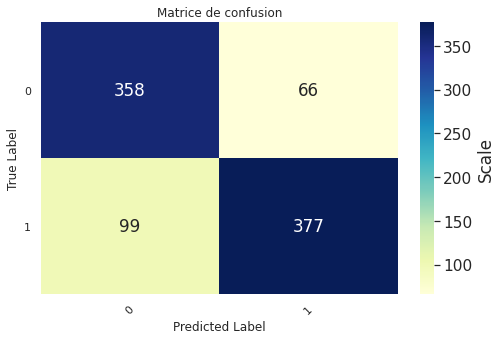

Sauvegarde du modèle dans  SentimentModel.pkl


In [ ]:
# selection des données
X=df_imdb.sentence
y=df_imdb.sentiment

#Cross validation
# Création d'un jeu d'apprentissage et de test
trainsize=0.7 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour le test

testsize= 0.3
seed=30
X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               train_size=trainsize, 
                                               random_state=seed,
                                               test_size=testsize)

pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer(lowercase='True')),
                   ('svm', SVC(C=1, gamma=1,kernel='rbf', verbose=True))])

pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)
MyshowAllScores(y_test,y_pred)

filename='SentimentModel.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))

# Test classifier imdb


**CHARGEMENT CLASSIFIER**

In [ ]:
filename = 'SentimentModel.pkl'

# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))

# affichage du modèle sauvegardé
print (clf_loaded)

**PREDICTION**

In [ ]:
# selection d'un echantillon
nbsamples=800
df_sample=df_movie.sample(n = nbsamples) 

print ("\nPrédiction sur ",nbsamples," données tirées au hasard \n")       
y_test=df_sample.sentiment 
X=df_sample.sentence
y_pred = clf_loaded.predict(X)

# autres mesures et matrice de confusion
MyshowAllScores(y_test,y_pred)

# Generer des Avis


**LSTM + Embedding**

**Setup**

In [ ]:
# librairies gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors # to load gzip bin files with KeyedVectors.load_word2vec_format
from gensim import models
from gensim.models.word2vec import Word2Vec
import numpy as np

from gensim import models
model_stanford = models.KeyedVectors.load_word2vec_format("glove.6B.100d.w2vformat.txt", binary=False)

#https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding


# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# pre-pad sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
	return in_text

def get_embedding_matrix(embeddings,words,vocabulary_size,dimension):
  # Preparation de la matrice des embeddings embedding matrix
  embedding_matrix = np.zeros((vocabulary_size, dimension)) #(22 x 100)
  for word, i in words.word_index.items():
    try: # lever l'exception si un mot n'est pas trouvé dans les embeddings
        embedding_vector = embeddings.wv[word] 
        embedding_matrix[i] = embedding_vector
    except KeyError: # mot non trouvé dans les embeddings
        # print(word)
        pass
  return embedding_matrix

**Creation des embeddings**

In [ ]:
#PARAMETRES
df = df_movie #df_imdb, df_movie, df_tweet
sent = 1 #0, 1, 4 (pour tweet)
model_name = 'model_movie_positive.bin'

In [ ]:
# source text
object_dataframe = df[df['sentiment'] == sent].sentence[:800] 
data = ""
for r in object_dataframe:
  data += r # + '\n'

tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] #codage des mots

vocab_size = len(tokenizer.word_index) + 1 #pourquoi +1 ???
print('Vocabulary Size: %d' % vocab_size)

# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
	sequence = encoded[i-2:i+1]
	sequences.append(sequence)

# pad sequences
max_length = max([len(seq) for seq in sequences]) #taille de la sequence la plus longue ? 3
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre') #padding

# split into input and output elements
sequences = array(sequences) #utile??
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

DIMENSION=100 #max_length#20
embedding_matrix=get_embedding_matrix(model_stanford,tokenizer,vocab_size,DIMENSION)

Vocabulary Size: 15185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


**Entrainement et sauvegarde du model**

In [ ]:
#---------- model ---------------
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length-1))#, trainable=False)) 
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
model.fit(X, y, epochs=100, verbose=2)
model.save(model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 100)            1518500   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 15185)             774435    
Total params: 2,323,135
Trainable params: 2,323,135
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
5810/5810 - 130s - loss: 6.7694 - accuracy: 0.0926
Epoch 2/100
5810/5810 - 129s - loss: 6.0276 - accuracy: 0.1302
Epoch 3/100
5810/5810 - 129s - loss: 5.6570 - accuracy: 0.1479
Epoch 4/100
5810/5810 - 130s - loss: 5.3769 - accuracy: 0.1627
Epoch 5/100
5810/5810 - 129s - loss: 5.1482 - accuracy: 0.1767
Epoch 6/100
5810/5810 - 131s - loss: 4.9493 - accuracy: 

INFO:tensorflow:Assets written to: model_movie_positive.bin/assets


INFO:tensorflow:Assets written to: model_movie_positive.bin/assets


**Test du modèle générateur**

In [ ]:
new_model = keras.models.load_model(model_name)

print(generate_seq(new_model, tokenizer, max_length-1, 'I am', 20))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I am sure the ending is a great deal of this movie is a great deal of this movie is a great


# Experimentation 1 - Generateur imdb / classifier movie


Principe :
  
  Partie: I

  - Entrainer un classifier --> relever l'accuracy
  - Génerer des avis positifs de taille variables (10, 20 mots)
  - Classer les données générés
  
  Partie II:

  -Ré-entrainer le classifier en changeant une partie des données par les données générés --> relever l'accuracy
  -Générer de nouveaux avis positifs
  - Les classer

**POSITIVE**

In [ ]:
generator = keras.models.load_model('model_opinions_embeddings.bin')

#générer des mots
nb = 500

generated_text = []
for i in range(nb):
  start = np.random.randint(0, len(X)-1) 
  pattern = X[start] 
  txt = ""
  for w in pattern:
    for word, index in tokenizer.word_index.items():
      if index == w:
        txt += word + ' '
  generated_text.append(generate_seq(generator, tokenizer, max_length-1, txt, 10 if i<nb/2 else 20))

print(np.matrix(generated_text))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[['and trilogy  i think the quality is excellent it fits comfortably came'
  'but deadly  in her taste for blood and evil if you want'
  'movie for  anyone interested in art poetry theater politics or japanese history'
  'single sour  note struck acting wise either some surprisingly solid casting here'
  'sublimely moving  it felt like a charm works as advertised comfortable nice'
  "very impressed  with the phone is sturdy enough i don't know exactly"
  'when i  saw this film is an excellent job of tying up'
  'essence of  the film is an excellent job of tying up the'
  'ribeye steak  was amazing omelets are to die for this place is'
  'not make  phone too bulky a usable keyboard actually turns a pda'
  'jabra bt250v  for those who are looking for the price is reasonable'
  "where spice  didn't over whelm the soup we were staying at the"
  'one of  the film is an excellent job of tying up the'
  'is not  to be the hardest decision honestly all of the film'
  'service a  unique feeling

Accuracy : 0.894
Classification Report
              precision    recall  f1-score   support

         0.0    0.00000   0.00000   0.00000         0
         1.0    1.00000   0.89400   0.94403       500

    accuracy                        0.89400       500
   macro avg    0.50000   0.44700   0.47202       500
weighted avg    1.00000   0.89400   0.94403       500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


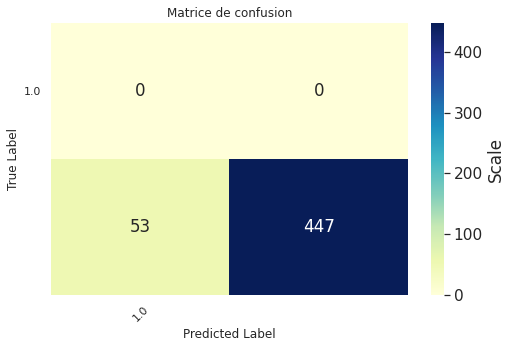

[0.9, 0.95, 0.95, 0.8, 0.95, 0.7, 0.95, 0.9, 0.85, 0.85, 0.9, 1.0, 1.0, 0.9, 0.9, 1.0, 0.85, 0.9, 0.85, 1.0, 0.95, 0.95, 0.95, 0.95, 0.95]
moyenne 0.9139999999999999
medianne 0.95
ecart-type 0.06858571279792898


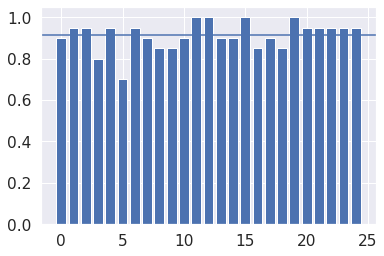

In [ ]:
classifier = pickle.load(open('NewSentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_text)
# print(y_pred)
MyshowAllScores(np.ones(nb),y_pred)

scores = []
for i in range(25):
  idx = np.random.randint(0, 500, 20);
  sample = np.array(generated_text)[idx]
  y_pred = classifier.predict(sample)
  # print(y_pred)
  # MyshowAllScores(np.ones(20),y_pred)
  scores.append(accuracy_score(np.ones(20), y_pred))

print(scores)
print("moyenne",np.average(scores))
print("medianne",np.median(scores))
print("ecart-type",np.nanstd(scores))

plt.bar(range(len(scores)), scores)
plt.axhline(y=np.average(scores))
plt.show()

**NEGATIVE**

In [ ]:
generator = keras.models.load_model('model_opinions_negative_embeddings.bin')

#générer des mots
nb = 500

generated_negative_text = []
for i in range(nb):
  start = np.random.randint(0, len(X)-1) 
  pattern = X[start] 
  txt = ""
  for w in pattern:
    for word, index in tokenizer.word_index.items():
      if index == w:
        txt += word + ' '
  generated_negative_text.append(generate_seq(generator, tokenizer, max_length-1, txt, 10 if i<nb/2 else 20))

print(np.matrix(generated_negative_text))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[['44 until  i plugged it in the proceedings is totally implausible and'
  "i've stepped  foot into this one i could not recommend this item"
  'good enough  for me at postinos hope your experience is betteri got'
  'roast beef  were bland the pan cakes everyone are raving about taste'
  'it was  a bit of a movie that is screened in the'
  "minutes yet  still no food i have ever seen he surely doesn't"
  'was terrible  it kept getting worse and i had to pull out'
  'the wienerschnitzel  is not a good way i swung in to give'
  "device is  turned off i don't think i've ever had a few"
  'the end  of days is one of the worst i have ever'
  'to be  a reasonable explanation for this chick that he expected it'
  'brother in  law who works at the time the film a truly'
  'the film  a truly truly bad film the football scenes at the'
  "to finish  it it suddenly died mic doesn't work here the visual"
  'but this  movie is a bit of a movie that is screened'
  'people like  morgan freeman jonah h

Accuracy : 0.772
Classification Report
              precision    recall  f1-score   support

         0.0    1.00000   0.77200   0.87133       500
         1.0    0.00000   0.00000   0.00000         0

    accuracy                        0.77200       500
   macro avg    0.50000   0.38600   0.43567       500
weighted avg    1.00000   0.77200   0.87133       500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


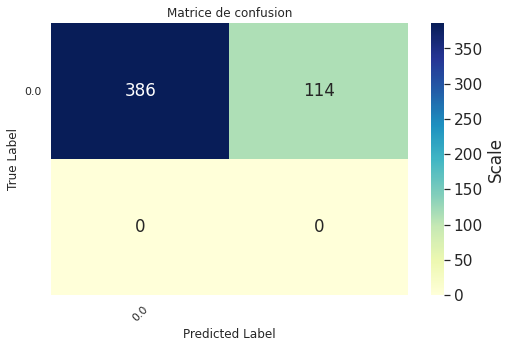

[0.8, 0.65, 0.8, 0.7, 0.85, 0.65, 0.7, 0.7, 0.8, 0.65, 0.8, 0.9, 0.85, 0.85, 0.9, 0.7, 0.8, 0.85, 0.85, 0.6, 0.75, 0.65, 0.75, 0.65, 0.8]
moyenne 0.7600000000000001
medianne 0.8
ecart-type 0.08717797887081348


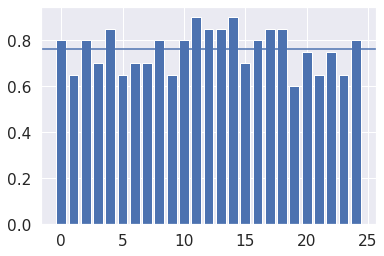

In [ ]:
classifier = pickle.load(open('NewSentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_negative_text)
# print(y_pred)
MyshowAllScores(np.zeros(nb),y_pred)

scores = []
for i in range(25):
  idx = np.random.randint(0, 500, 20);
  sample = np.array(generated_negative_text)[idx]
  y_pred = classifier.predict(sample)
  # print(y_pred)
  # MyshowAllScores(np.zeros(20),y_pred)
  scores.append(accuracy_score(np.zeros(20), y_pred))

print(scores)
print("moyenne",np.average(scores))
print("medianne",np.median(scores))
print("ecart-type",np.nanstd(scores))

plt.bar(range(len(scores)), scores)
plt.axhline(y=np.average(scores))
plt.show()

**Mixte**

Accuracy : 0.852
Classification Report
              precision    recall  f1-score   support

         0.0    0.90367   0.78800   0.84188       250
         1.0    0.81206   0.91600   0.86090       250

    accuracy                        0.85200       500
   macro avg    0.85786   0.85200   0.85139       500
weighted avg    0.85786   0.85200   0.85139       500



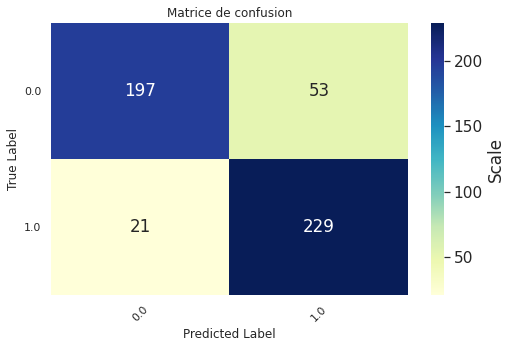

[0.8, 0.85, 0.8, 0.8, 0.95, 0.95, 0.95, 0.9, 0.8, 0.9, 0.8, 0.75, 0.9, 0.9, 0.7, 0.8, 0.85, 0.9, 0.9, 0.75, 0.85, 0.85, 0.9, 0.9, 0.75]
moyenne 0.848
medianne 0.85
ecart-type 0.06852736679604725


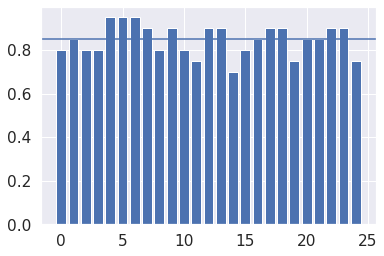

In [ ]:
y_true = np.concatenate( (np.ones(int(nb/2)),np.zeros(int(nb/2))), axis=0)

idx = np.random.randint(0, 500, 250);
x_test = np.concatenate( (np.array(generated_text)[idx], np.array(generated_negative_text)[idx] ), axis=0)

classifier = pickle.load(open('NewSentimentModel.pkl', 'rb'))
y_pred = classifier.predict(x_test)
# print(y_pred)
MyshowAllScores(y_true,y_pred)

scores = []
for i in range(25):
  idx = np.random.randint(0, 500, 20);
  sample = x_test[idx]
  sample_true = y_true[idx]
  y_pred = classifier.predict(sample)
  # print(y_pred)
  # MyshowAllScores(sample_true,y_pred)
  scores.append(accuracy_score(sample_true, y_pred))

print(scores)
print("moyenne",np.average(scores))
print("medianne",np.median(scores))
print("ecart-type",np.nanstd(scores))

plt.bar(range(len(scores)), scores)
plt.axhline(y=np.average(scores))
plt.show()

# Experimentation 2 - Generateur tweet / classifier imdb

**POSTIVE**

In [ ]:
generator = keras.models.load_model('model_tweet_positive.bin')

#générer des mots
nb = 100

generated_text = []
for i in range(nb):
  start = np.random.randint(0, len(X)-1) 
  pattern = X[start] 
  txt = ""
  for w in pattern:
    for word, index in tokenizer.word_index.items():
      if index == w:
        txt += word + ' '
  generated_text.append(generate_seq(generator, tokenizer, max_length-1, txt, 10 if i<nb/2 else 20))

print(np.matrix(generated_text))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[["america's cto  morning sunny morning in the morning i have a great"
  'its off  to work today kaitlyn still bleh her word i knew'
  'so good  was ridiculously tired last night and i have a great'
  "boy's life  getting ready for a while ago tomfelton seems 2 hours"
  'plato and  am now listening to mcfly what a wonderful day havidaemmarkl'
  "i did  it work won't it timnoonan you should have to do"
  'missu oh  ok talater ask tweetdeck if it is just a few'
  'actually catch  it down sharpish is last night and i have a'
  'guess sorry  http twitpic com 2y606 gorgeous you just got back to'
  'is very  happy with the girls are begging to if the contest'
  'one of  those days i got to see the sun is shining'
  "back when  my dad's gps died trying to get up and having"
  'hours ago  waiting for the next time i have a great day'
  'of colours  to make it all is well with your amp the'
  "sleepy still  that i'm going to be a good day everyone got"
  'decided to  have a great day everyone g

In [ ]:
classifier = pickle.load(open('NewSentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_text)
print(y_pred)
MyshowAllScores(np.ones(nb),y_pred)

classifier = pickle.load(open('SentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_text)
print(y_pred)
MyshowAllScores(np.ones(nb),y_pred)

# scores = []
# for i in range(5):
#   idx = np.random.randint(0, 100, 20);
#   sample = np.array(generated_text)[idx]
#   y_pred = classifier.predict(sample)
#   print(y_pred)
#   MyshowAllScores(np.ones(20),y_pred)
#   scores.append(accuracy_score(np.ones(20), y_pred))

# print(scores)
# print(np.average(scores))
# print(np.nanstd(scores))

# Experimentation 3 - Generateur movie / classifier imdb

**POSITIVE**

In [ ]:
generator = keras.models.load_model('model_movie_positive.bin')

#générer des mots
nb = 1000

generated_text = []
for i in range(nb):
  start = np.random.randint(0, len(X)-1) 
  pattern = X[start] 
  txt = ""
  for w in pattern:
    for word, index in tokenizer.word_index.items():
      if index == w:
        txt += word + ' '
  generated_text.append(generate_seq(generator, tokenizer, max_length-1, txt, 10 if i<nb/2 else 20))

print(np.matrix(generated_text))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[["the world's  best films ever made it seemed to be a bit"
  'now english  in cinema history is a great deal of this movie'
  'students who  have been better as a film that is the best'
  'was a  very good and the film is a great deal of'
  'the man  who knew too much is that the film is a'
  "wasn't pretentious  or ordinary in morocco and london studios by cameraman robert"
  'forget about  the story is about the story is about the story'
  "j e  b stuart opposite ronald reagan's ear and he tells him"
  'ha ha  this movie is a great deal of this movie is'
  'tend to  think about it is a great deal of this movie'
  'piece set  in the film is a great deal of this movie'
  'of blackmail  br br the film is a great deal of this'
  'is just  as much as a film that is the best movies'
  'with another  reviewer who gets to tell the rest of the film'
  'feeble mind  a bit of the film is a great deal of'
  "in historical  dramas though it's not a huge fan of this movie"
  'cheer up  any droopy

Accuracy : 0.874
Classification Report
              precision    recall  f1-score   support

         0.0    0.00000   0.00000   0.00000         0
         1.0    1.00000   0.87400   0.93276      1000

    accuracy                        0.87400      1000
   macro avg    0.50000   0.43700   0.46638      1000
weighted avg    1.00000   0.87400   0.93276      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


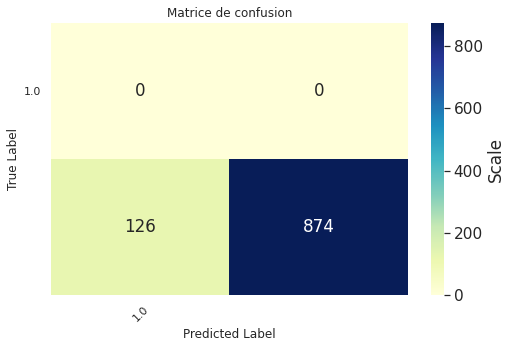

[0.85, 0.65, 0.75, 1.0, 0.8, 0.7, 0.8, 0.65, 0.8, 0.85, 0.75, 0.85, 0.75, 0.75, 0.75, 0.95, 0.7, 0.8, 0.9, 0.85, 0.75, 0.9, 0.8, 0.8, 0.7]
moyenne 0.7939999999999999
medianne 0.8
ecart-type 0.08522910301065006


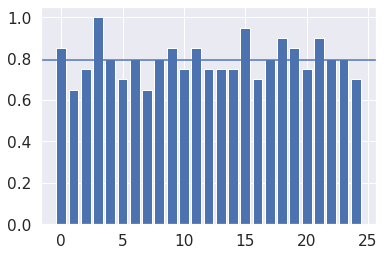

In [ ]:
classifier = pickle.load(open('SentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_text)
# print(y_pred)
MyshowAllScores(np.ones(nb),y_pred)

scores = []
for i in range(25):
  idx = np.random.randint(0, 500, 20);
  sample = np.array(generated_text)[idx]
  y_pred = classifier.predict(sample)
  # print(y_pred)
  # MyshowAllScores(np.ones(20),y_pred)
  scores.append(accuracy_score(np.ones(20), y_pred))

print(scores)
print("moyenne",np.average(scores))
print("medianne",np.median(scores))
print("ecart-type",np.nanstd(scores))

plt.bar(range(len(scores)), scores)
plt.axhline(y=np.average(scores))
plt.show()

**Rentrainement**

In [ ]:
y_pred = classifier.predict(generated_text)
gen_pos = np.array(generated_text)[y_pred == 1]

X=df_imdb.sentence
y=df_imdb.sentiment

X_pos = X[y==1]
X_neg = X[y==0]

pourcentage = 0.3
X_pos_size = X_pos.shape[0]
nb = int(X_pos_size * pourcentage)

X_train_pos = np.concatenate( (X_pos[:(X_pos_size-nb)], gen_pos[:nb]), axis=0)
X_train = np.concatenate( (X_train_pos, X_neg), axis=0)
X_test = X_pos[-nb:]

y_train = np.concatenate( (np.ones(1500), np.zeros(1500)), axis=0)
y_test = np.ones(nb)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer(lowercase='True')),
                   ('svm', SVC(C=1, gamma=1,kernel='rbf', verbose=True))])

pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)
MyshowAllScores(y_test,y_pred)
